In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 25.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.9/539.9 kB 21.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 5.9 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8

In [3]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 7.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error,r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
import xgboost as xgb
data=pd.read_csv('Hourly Load Data.csv')


In [12]:
data

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0
...,...,...
32891,2001-01-01 20:00:00,35209.0
32892,2001-01-01 21:00:00,34791.0
32893,2001-01-01 22:00:00,33669.0
32894,2001-01-01 23:00:00,31809.0


### Feature engineering


In [8]:
data.Datetime=pd.to_datetime(data.Datetime)
data['year']=data.Datetime.dt.year.astype(object)
data['month']=data.Datetime.dt.month
data['dayofmonth']=data.Datetime.dt.day.astype(object)
data['hour']=data.Datetime.dt.hour.astype(object)
data['dayofyear']=data.Datetime.dt.dayofyear
data['weekday']=data.Datetime.dt.weekday
data['date']=data.Datetime.dt.date
data['wntr_month']=data.apply(lambda x: 1 if x.month in ([11,12,1,2]) else 0,axis=1) 
data['wntr_month']=data['wntr_month'].astype(object)
data['hour_label']=pd.cut(data.hour,bins=[0,5,10,15,20,24], labels=[0,1,2,3,0],ordered=False,right=False)
data['month_label']=data.month.map(lambda x : '1' if x in ([11,12,1,2,3]) else ( '2' if x in ([6,7,8,9]) else '3' ))
data['quarter']=data.month.map(lambda x : '1_çeyrek' if x in ([1,2,3]) else ( '2_çeyrek' if x in ([4,5,6]) else( '3_çeyrek' if x in ([7,8,9]) else '4_çeyrek') ))
data['season']=data.month.map(lambda x : 'kış' if x in ([12,1,2]) else ( 'ilkbahar' if x in ([3,4,5]) else( 'yaz' if x in ([6,7,8]) else 'sonbahar') ))
data['weekend']=data.dayofmonth.map(lambda x:  'hafta_içi' if x<5 else 'hafta_sonu')
data['working_hours']=data.hour.map(lambda x: 'work_hour' if (x<7) & (x>19) else 'not_work_hour' )

data.set_index('Datetime',inplace=True)
data=data.sort_index()
data=data.iloc[:-1]

In [9]:
data

,PJM_Load_MW,year,month,dayofmonth,hour,dayofyear,weekday,date,wntr_month,hour_label,month_label,quarter,season,weekend,working_hours
Datetime,,,,,,,,,,,,,,,
1998-04-01 01:00:00,22259.0,1998,4,1,1,91,2,1998-04-01,0,0,3,2_çeyrek,ilkbahar,hafta_içi,not_work_hour
1998-04-01 02:00:00,21244.0,1998,4,1,2,91,2,1998-04-01,0,0,3,2_çeyrek,ilkbahar,hafta_içi,not_work_hour
1998-04-01 03:00:00,20651.0,1998,4,1,3,91,2,1998-04-01,0,0,3,2_çeyrek,ilkbahar,hafta_içi,not_work_hour
1998-04-01 04:00:00,20421.0,1998,4,1,4,91,2,1998-04-01,0,0,3,2_çeyrek,ilkbahar,hafta_içi,not_work_hour
1998-04-01 05:00:00,20713.0,1998,4,1,5,91,2,1998-04-01,0,1,3,2_çeyrek,ilkbahar,hafta_içi,not_work_hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 19:00:00,37570.0,2001,12,31,19,365,0,2001-12-31,1,3,1,4_çeyrek,kış,hafta_sonu,not_work_hour
2001-12-31 20:00:00,36392.0,2001,12,31,20,365,0,2001-12-31,1,0,1,4_çeyrek,kış,hafta_sonu,not_work_hour
2001-12-31 21:00:00,35082.0,2001,12,31,21,365,0,2001-12-31,1,0,1,4_çeyrek,kış,hafta_sonu,not_work_hour


In [5]:
# Mean ve median değerlerimiz yakın standtart sapmamız çok yüksek değil ortalama etrafında bir dağılım  olduğunu gösterir
print(f'mode:{data.PJM_Load_MW.mode()[0]}')
# Mean median mode değerlerine bakacak olursak dağımımız pozitif skewed diyebiliriz 
data.describe().T

mode:30723.0


,count,mean,std,min,25%,50%,75%,max
PJM_Load_MW,32895.0,29766.372610,5849.850428,17461.0,25473.0,29655.0,33073.5,54030.0
month,32895.0,6.819881,3.346490,1.0,4.0,7.0,10.0,12.0
dayofyear,32895.0,192.161544,102.362292,1.0,109.0,194.0,280.0,366.0
weekday,32895.0,3.000760,1.999749,0.0,1.0,3.0,5.0,6.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32895 entries, 1998-04-01 01:00:00 to 2001-12-31 23:00:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PJM_Load_MW    32895 non-null  float64 
 1   year           32895 non-null  object  
 2   month          32895 non-null  int64   
 3   dayofmonth     32895 non-null  object  
 4   hour           32895 non-null  object  
 5   dayofyear      32895 non-null  int64   
 6   weekday        32895 non-null  int64   
 7   date           32895 non-null  object  
 8   wntr_month     32895 non-null  object  
 9   hour_label     32895 non-null  category
 10  month_label    32895 non-null  object  
 11  quarter        32895 non-null  object  
 12  season         32895 non-null  object  
 13  weekend        32895 non-null  object  
 14  working_hours  32895 non-null  object  
dtypes: category(1), float64(1), int64(3), object(10)
memory usage: 3.8+ MB


In [7]:
data.isnull().sum() #datamız temiz null yok

PJM_Load_MW      0
year             0
month            0
dayofmonth       0
hour             0
dayofyear        0
weekday          0
date             0
wntr_month       0
hour_label       0
month_label      0
quarter          0
season           0
weekend          0
working_hours    0
dtype: int64

In [8]:
data[data.duplicated()] #data da duplicated değer yok

,PJM_Load_MW,year,month,dayofmonth,hour,dayofyear,weekday,date,wntr_month,hour_label,month_label,quarter,season,weekend,working_hours
Datetime,,,,,,,,,,,,,,,


In [9]:
data.year.value_counts()

2000    8782
1999    8758
2001    8758
1998    6597
Name: year, dtype: int64

#### outliers
* outlierları kontrol ettiğimizde outlierlar genelde yaz aylarında 

In [10]:
outlier_treshold_up=data.PJM_Load_MW.std()*2.5+data.PJM_Load_MW.mean()
outlier_treshold_down=data.PJM_Load_MW.mean()-data.PJM_Load_MW.std()*2.5
print(f'outlier_treshold_up: {outlier_treshold_up:.2f},\noutlier_treshold_down: {outlier_treshold_down:.2f}')

outlier_treshold_up: 44391.00,
outlier_treshold_down: 15141.75


In [11]:
# Datamızda  çok küçük değerlerden kaynaklanan bir outlier durumumuz yok
data[data.PJM_Load_MW<outlier_treshold_down]

,PJM_Load_MW,year,month,dayofmonth,hour,dayofyear,weekday,date,wntr_month,hour_label,month_label,quarter,season,weekend,working_hours
Datetime,,,,,,,,,,,,,,,


In [12]:
# Data da bu saatler eksik.Herhangi bir özel durum bulamadım.
a=list(pd.date_range(start='1998-04-01 01:00:00', end='2001-12-31 23:00:00', freq='H'))
set(a)-set(data.index)

{Timestamp('1998-04-05 03:00:00', freq='H'),
 Timestamp('1998-10-25 02:00:00', freq='H'),
 Timestamp('1999-04-04 03:00:00', freq='H'),
 Timestamp('1999-10-31 02:00:00', freq='H'),
 Timestamp('2000-04-02 03:00:00', freq='H'),
 Timestamp('2000-10-29 02:00:00', freq='H'),
 Timestamp('2001-04-01 03:00:00', freq='H'),
 Timestamp('2001-10-28 02:00:00', freq='H')}

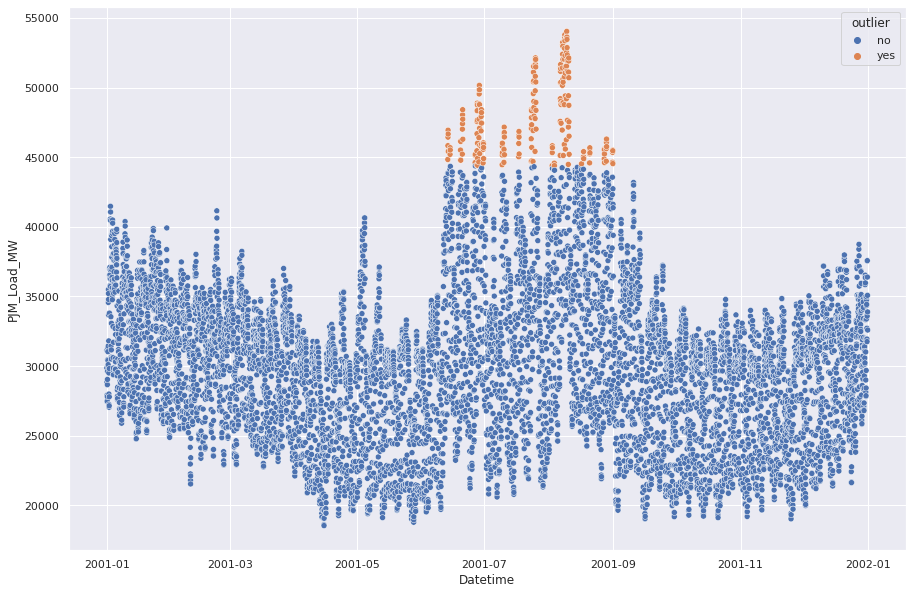

In [13]:
# Tek bir yıl için çizdirdim daha detayli görülebilmesi için.
# Outlierlarımız  genelde yaz aylarında gözlemleniyor.
sns.set(rc={'figure.figsize':(15,10)})
dum=data[data.year==2001].copy()
dum['outlier'] =dum['outlier'] = np.where(dum['PJM_Load_MW']>outlier_treshold_up, 'yes', 'no')
sns.scatterplot(x=dum.index,y='PJM_Load_MW',data=dum,hue=dum.outlier);

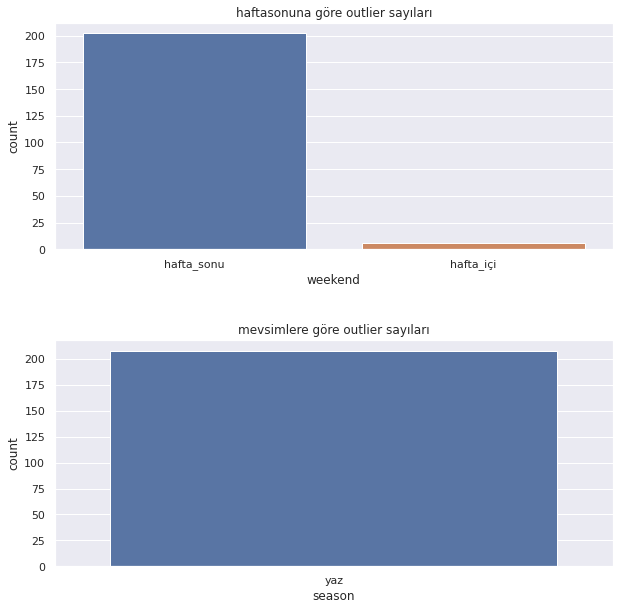

In [14]:
# Outlierlarımız yaz aylarında ve hafta sonlarında görülmekte buda mantıklı.
# Yıl içerisindeki primetime olarak değerlendirebilceğimiz dönemlerde outlierlarımız var.
sns.set(rc={'figure.figsize':(10,10)})
plt.subplot(2,1,1)
sns.countplot(x=dum[dum.outlier=='yes'].weekend).set_title('haftasonuna göre outlier sayıları');plt.subplot(2,1,2)
plt.subplots_adjust(hspace = 0.4)
sns.countplot(x=dum[dum.outlier=='yes'].season).set_title('mevsimlere göre outlier sayıları');

### 2-Descriptive Statistics: Veriyi bir zaman serisi olarak plot ederek gözlemlerinizi paylaşınız (saatlik, aylık, sezonluk, haftanın günleri).

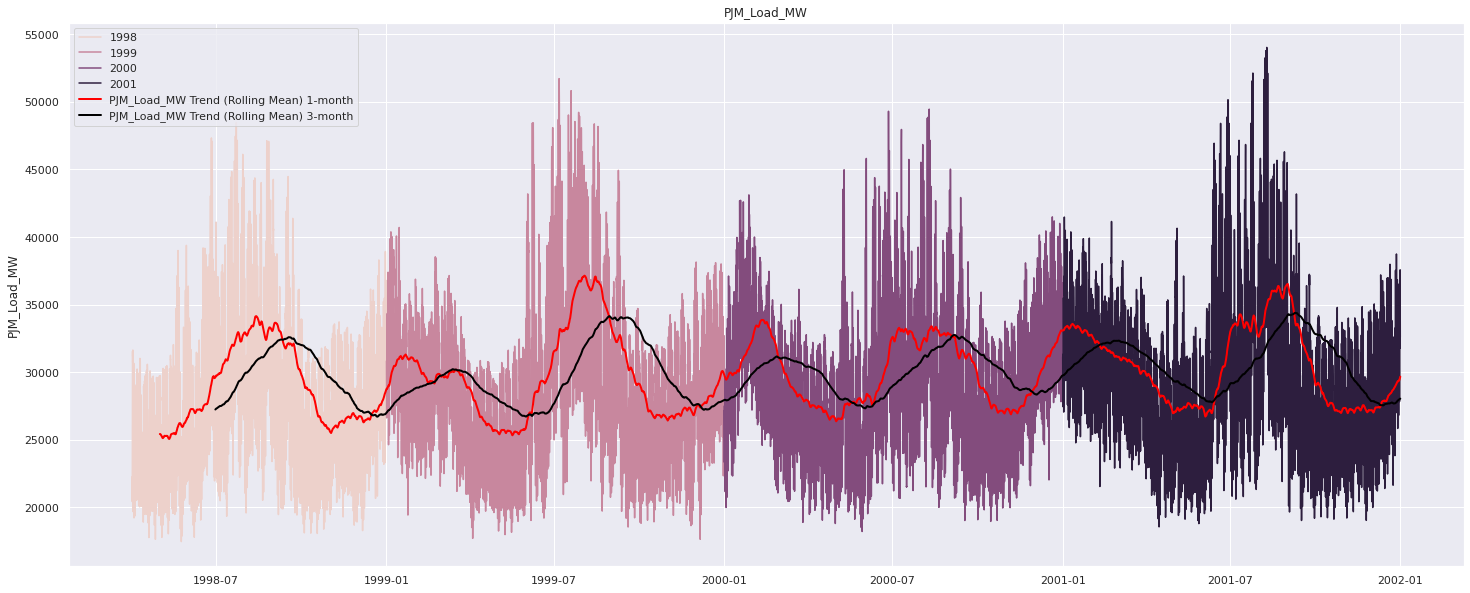

In [15]:
# Burada elektrik tüketiminde  sezonluk değişimlerin olduğu gözleniyor.
# Yine burada sezonsal bir durumun olduğunu gözlemleyebiliyoruz.
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(x=data.index.values, y="PJM_Load_MW", hue=data.year,data=data).set_title('PJM_Load_MW')
plt.plot(data.PJM_Load_MW.rolling(24*30).mean(), alpha=1, color='red', label='PJM_Load_MW Trend (Rolling Mean) 1-month', linewidth = 2.0)
plt.plot(data.PJM_Load_MW.rolling(24*30*3).mean(), alpha=1, color='black', label='PJM_Load_MW Trend (Rolling Mean) 3-month', linewidth = 2.0)
plt.legend();

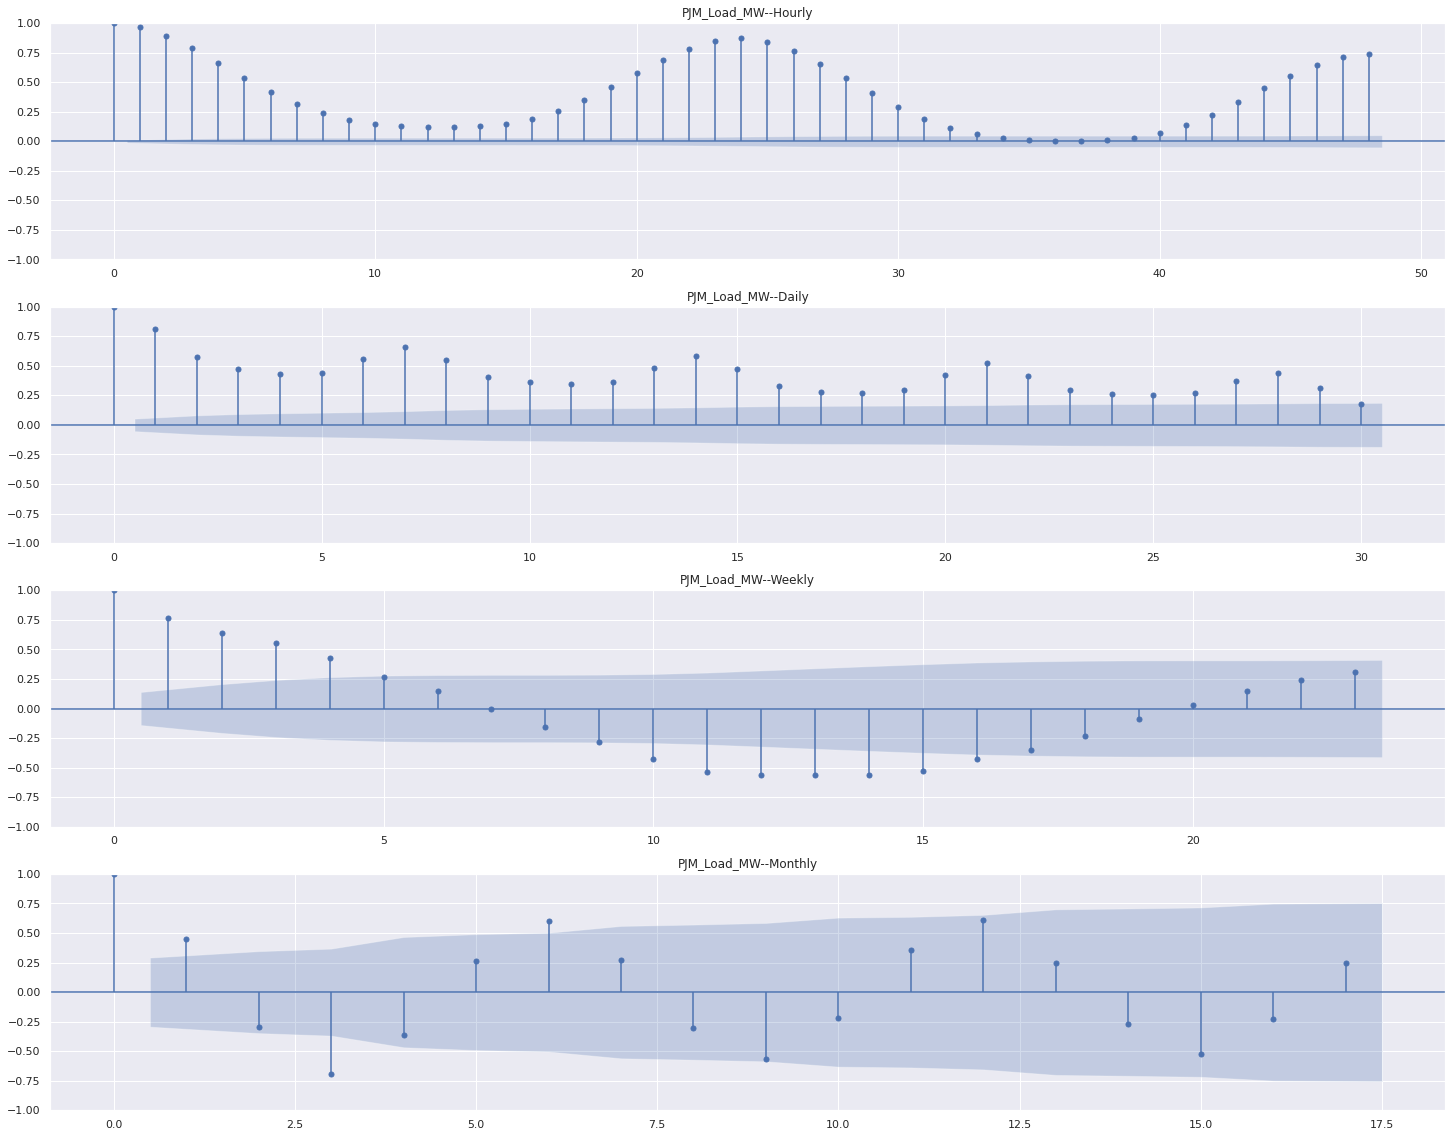

In [16]:
# Data içerisinde Auto-correlation gözlemliyoruz ki bu beklenmedik birşey değil.Yukarıdaki grafik bunun ipucunu veriyor.
# Grafiklerde verimizde günlük haftalık ve aylık trendlerin olduğunu görebiliyoruz.

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(25,20))
plot_acf(data.PJM_Load_MW,  title='PJM_Load_MW--Hourly',lags=48,ax=ax1)
plot_acf(data.PJM_Load_MW.resample('D').mean(),  title='PJM_Load_MW--Daily',lags=30,ax=ax2)
plot_acf(data.PJM_Load_MW.resample('W').mean(),  title='PJM_Load_MW--Weekly',ax=ax3)
plot_acf(data.PJM_Load_MW.resample('M').mean(),  title='PJM_Load_MW--Monthly',ax=ax4)
plt.show()

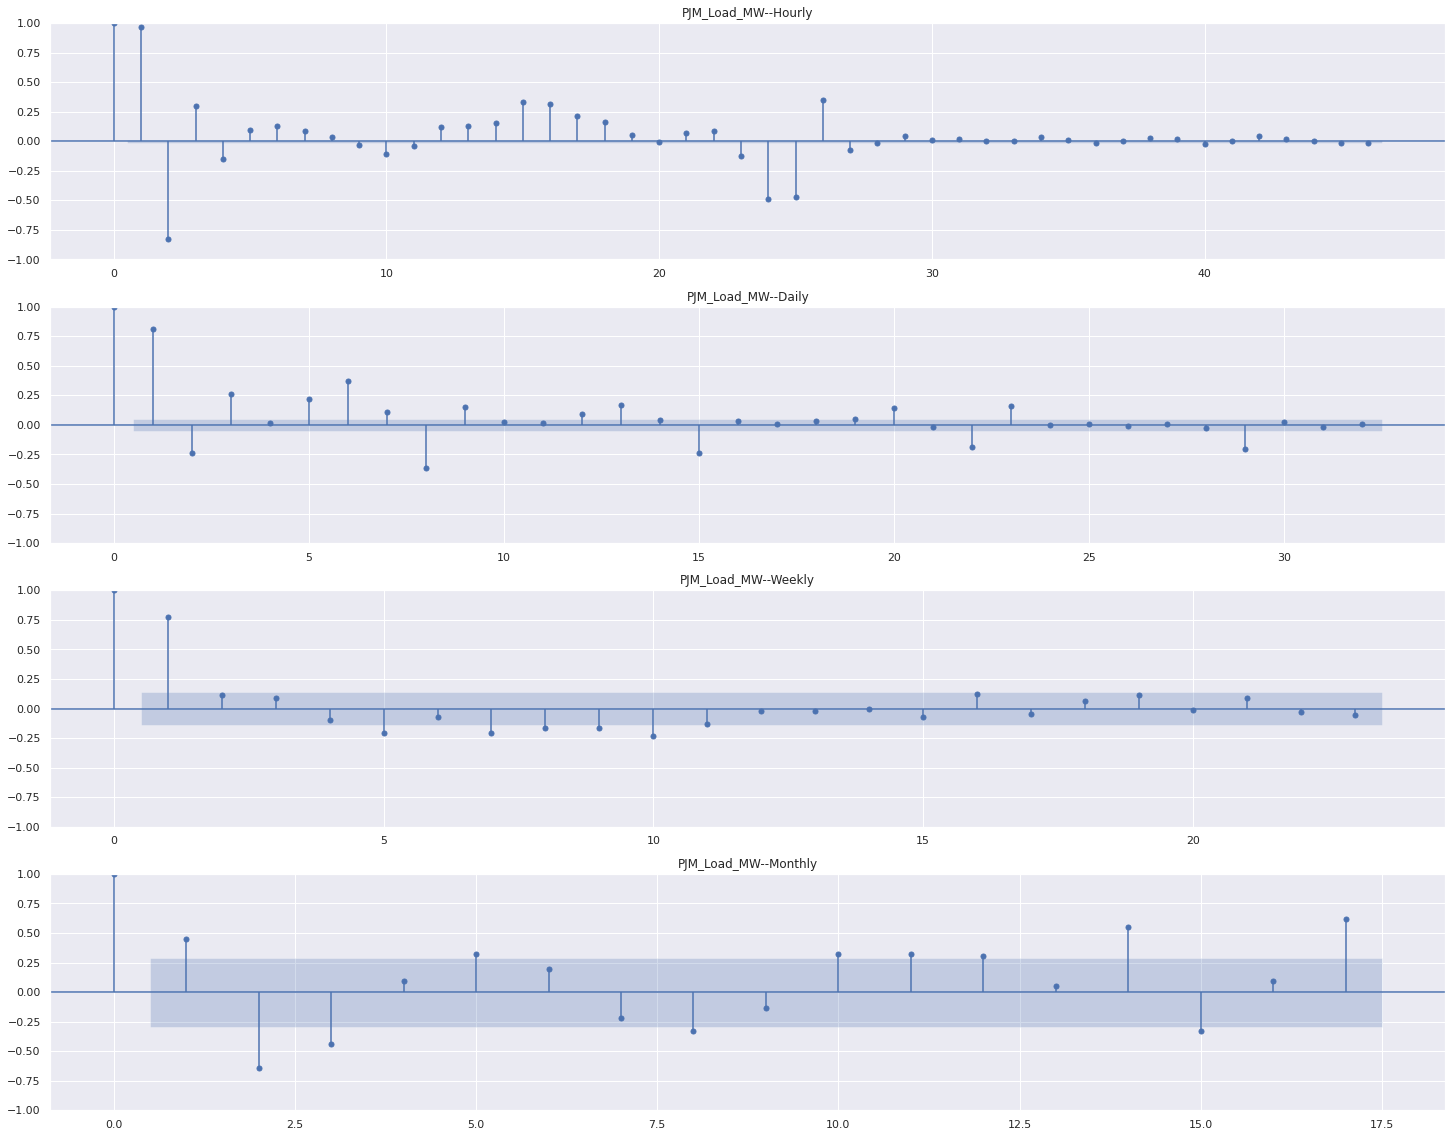

In [17]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(25,20))
plot_pacf(data.PJM_Load_MW,  title='PJM_Load_MW--Hourly',ax=ax1,method='ywm')
plot_pacf(data.PJM_Load_MW.resample('D').mean(),  title='PJM_Load_MW--Daily',ax=ax2,method='ols')
plot_pacf(data.PJM_Load_MW.resample('W').mean(),  title='PJM_Load_MW--Weekly',ax=ax3,method='ols')
plot_pacf(data.PJM_Load_MW.resample('M').mean(),  title='PJM_Load_MW--Monthly',ax=ax4,method='ols')

plt.show()

# Grafikte, 1.2. ve 3.  gecikmeler için kısmi kolerasyonlar yüksek.
# 1. grafikte 1.,2. ve 3. gecikmeler modele konulabilir.Kolerasyonları yüksek.
# Daily grafiğine bakınca birbirini takip iki gün arasında bir kolerasyonun varlığndan bahsedebiliriz.
# Weekly grafiğine bakınca yine birbirini takip eden haftalar arasında bir kolerasyonun varlığından bahsedebiliriz. Monthly grafiğinde bu nispeten daha az.

# lag featureları ekliyorum.
data["PJM_Load_MW_shift_2"]=data["PJM_Load_MW"].shift(-1)
data["PJM_Load_MW_shift_3"]=data["PJM_Load_MW"].shift(-2)
data["PJM_Load_MW_shift_4"]=data["PJM_Load_MW"].shift(-3)


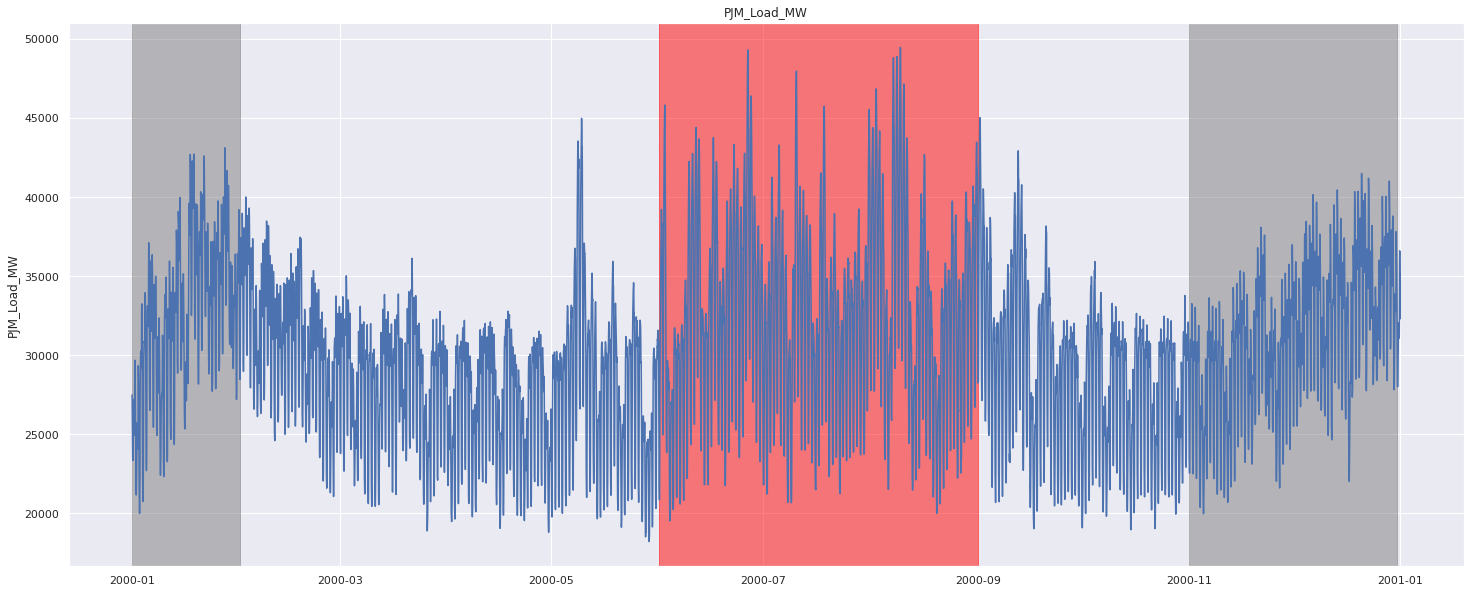

In [18]:
# Sadece bir  yıl için bakacak olursak yaz aylarında enerji tüketiminin en yüksek.
# Kış ayalarında da enerji tüketimi yüksek fakat ilkbahar ve sonbahar aylarında yaza ve kışa göre nispeten elektrik tüketimi daha az
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(x=data[data.year==2000].index.values, y="PJM_Load_MW",data=data[data.year==2000]).set_title('PJM_Load_MW');
plt.axvspan('2000-06-01 00:00:00','2000-09-01 00:00:00',color="red",alpha=0.5)
plt.axvspan('2000-01-01 00:00:00','2000-02-01 00:00:00',color="grey",alpha=0.5) 
plt.axvspan('2000-11-01 00:00:00','2000-12-31 00:00:00',color="grey",alpha=0.5) ;

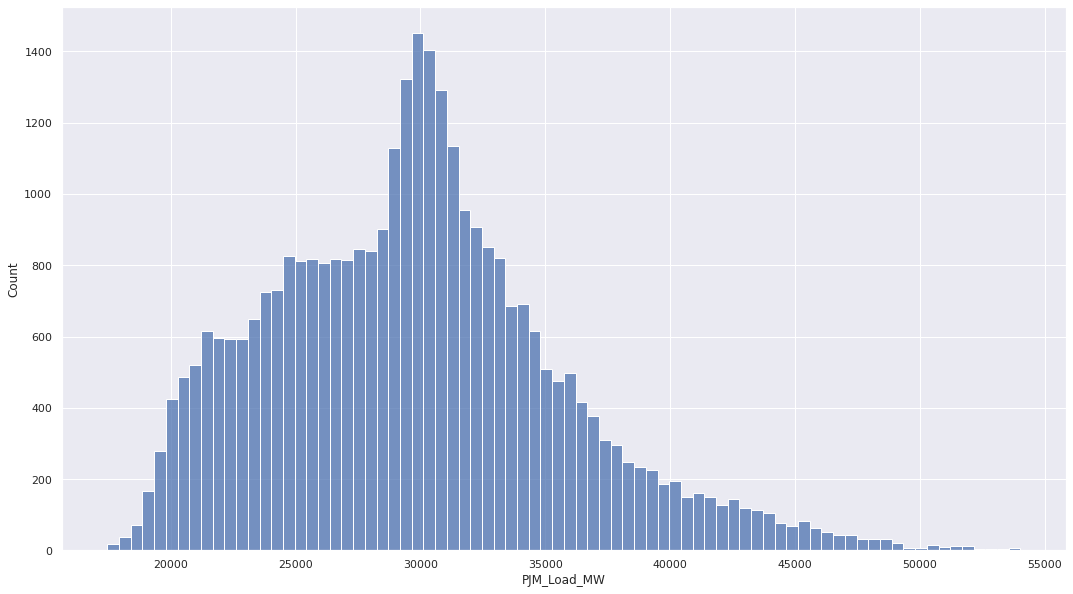

In [19]:
# Verimizin dağılımı normal değil.Dağılımın right skewed olduğunu söyleyebiliriz.
sns.set(rc={'figure.figsize':(18,10)})
sns.histplot(x=data.PJM_Load_MW);

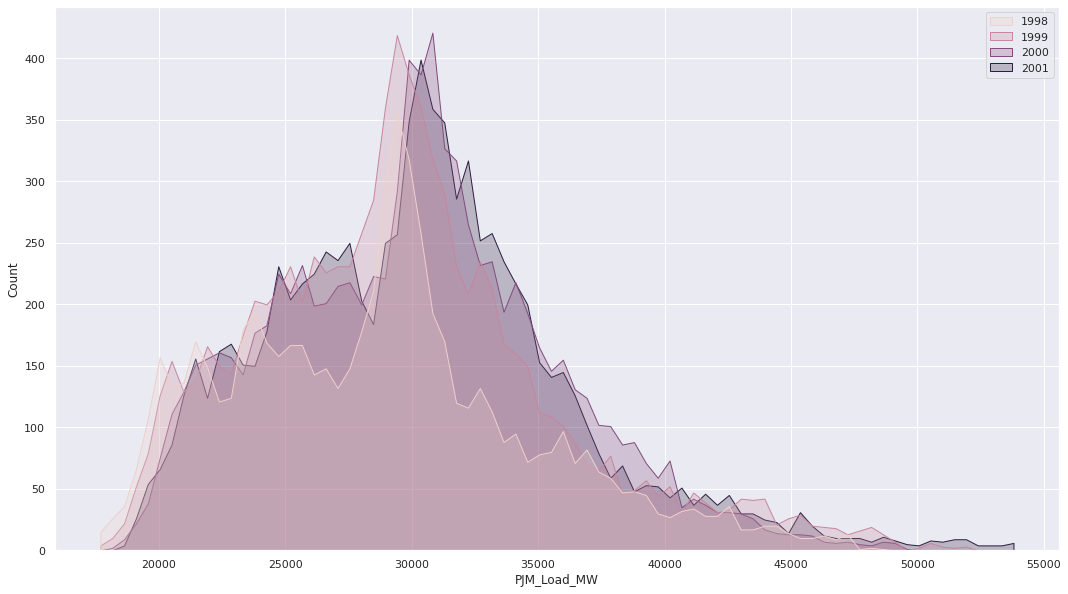

In [20]:
# Yıllara göre baktığımız da dağılımların birbine yakın olduğunu  gözlemleyebiliyoruz.
sns.histplot(x=data.PJM_Load_MW ,hue=data.year.values, element="poly");

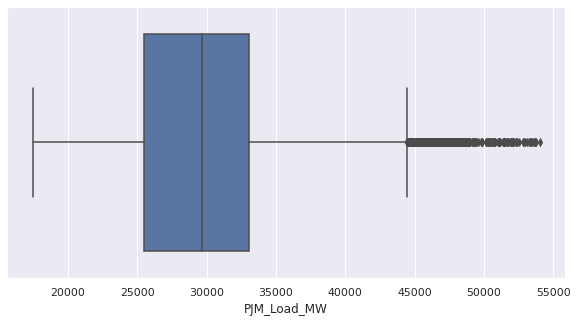

In [21]:
# Outlier değerler
# Outlierlar üzerinde bir işlem yapma gereği duymadım çünkü aşırı göze batan bir outlier durumumuz yok.
sns.set(rc={'figure.figsize':(10,5)})
sns.boxplot(x=data.PJM_Load_MW);

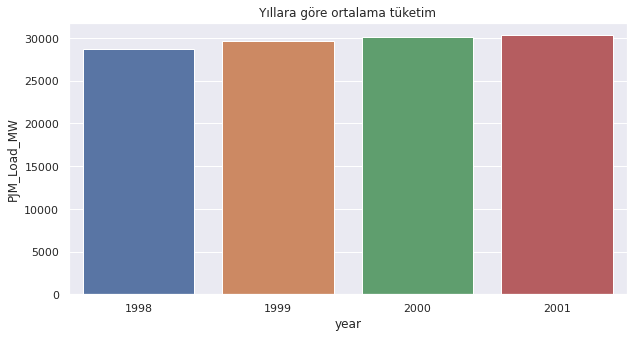

In [22]:
# Yıllara göre ortalama tüketimde  bir artış var.
dum=data.groupby(['year'])['PJM_Load_MW'].mean().reset_index()
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='year',y='PJM_Load_MW',data=dum).set_title('Yıllara göre ortalama tüketim');

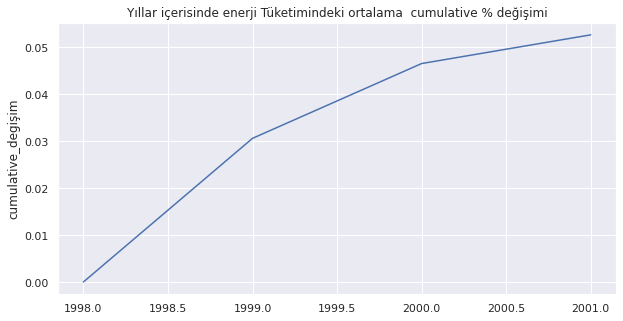

In [23]:
# Burada ortalama enerji tüketiminin yıllar içerisinde arttığını gözlemliyoruz ama artış hızında bir azalma var.
# 1998-2001 arasında ortalama tüketimde %4.6 artmış 3 yılda aslında çok az.
dum=data.groupby(['year'])['PJM_Load_MW'].mean().reset_index()
dum['cumulative_degişim']=dum.PJM_Load_MW.pct_change().cumsum().fillna(0)
ax=sns.set(rc={'figure.figsize':(10,5)})
ax=sns.lineplot(x=dum.year.values,y=dum.cumulative_degişim).set_title('Yıllar içerisinde enerji Tüketimindeki ortalama  cumulative % değişimi')

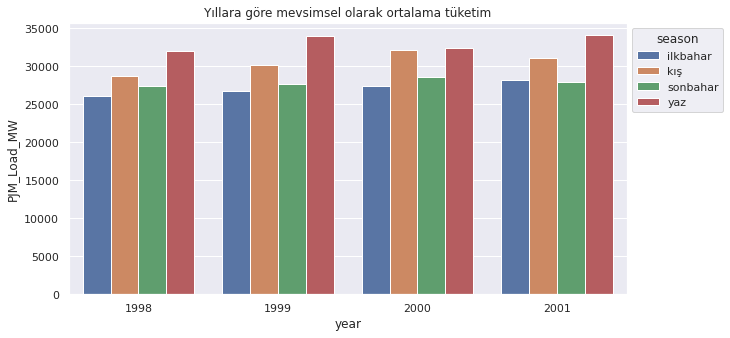

In [24]:
# Mevsimlik bazda ortalama tüketimler.
# Kış aylarında ısınma için kullanılan elektrik miktarının artması tüketimi artırabilir.
# Yaz aylarında soğutma için kullanılan elektrik miktarı elektrik tüketimini artırabilir.
dum=data.groupby(['year','season'])['PJM_Load_MW'].mean().reset_index()
sns.set(rc={'figure.figsize':(10,5)})
ax=sns.barplot(x='year',y='PJM_Load_MW',hue='season',data=dum)
ax.set_title('Yıllara göre mevsimsel olarak ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

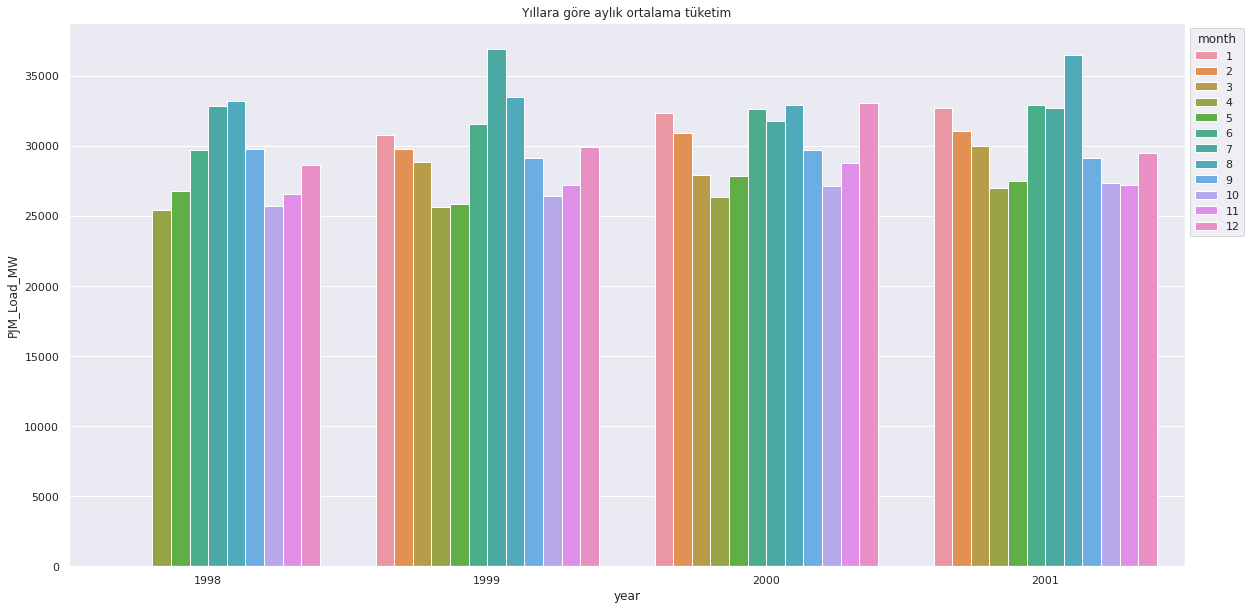

In [25]:
# Yıllara göre aylık ortalma tüketim miktarları
# Yine burada genel trendin yıllar içerisinde aynı olduğunu gözlemleyebiliriz.
# İlkbahar ve sonbahar aylarında yaz ve kış aylarına göre tüketim daha düşük kalmakta.
dum=data.groupby(['year','month'])[['PJM_Load_MW']].mean().reset_index()
sns.set(rc={'figure.figsize':(20,10)})
ax=sns.barplot(x='year',y='PJM_Load_MW',hue='month',data=dum)
ax.set_title('Yıllara göre aylık ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

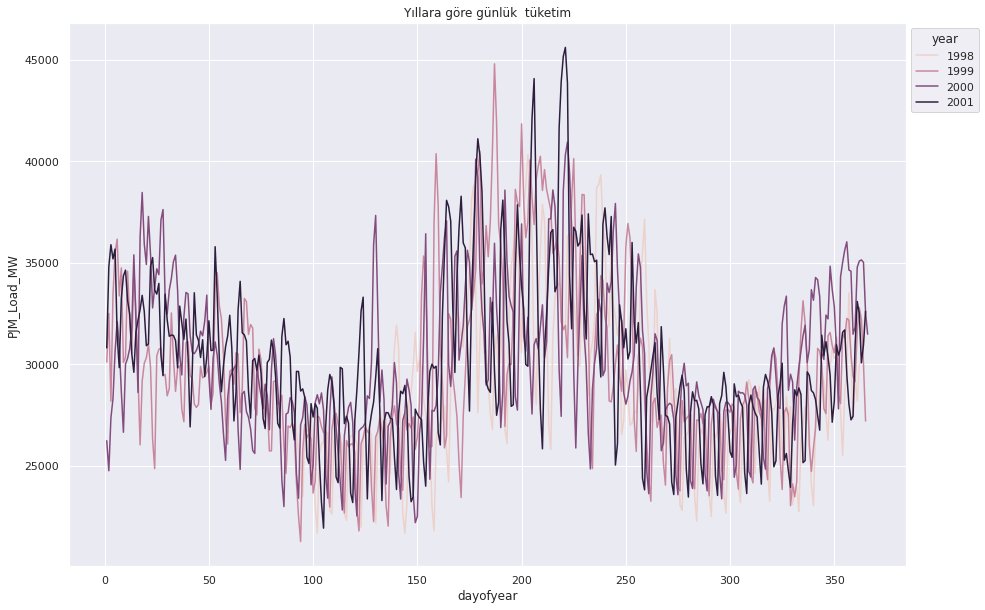

In [26]:
# Yine burada da yıllara göre günlük tüketim miktarlarını çizdirdim yaz ve kış günlerinde tüketim fazla
dum=data.groupby(['year','dayofyear'])[['PJM_Load_MW']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.dayofyear,y=dum.PJM_Load_MW,hue=dum.year,legend=all)
ax.set_title('Yıllara göre günlük  tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

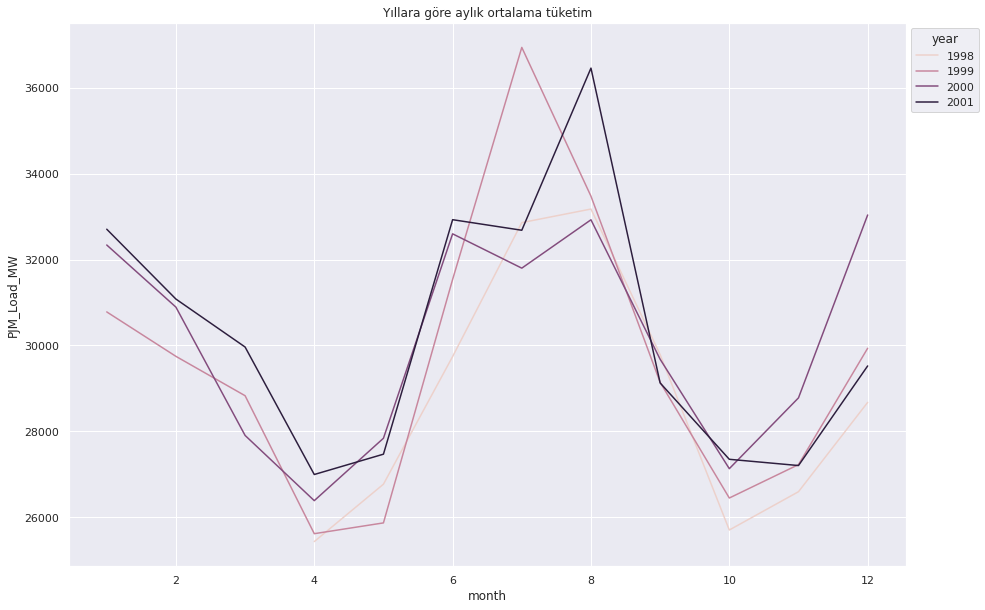

In [27]:
# Aylara göre batığımızda bir seasonality gözlemliyoruz ilkbahar ve sonhar aylarında enerji tüketimi yaz ve kış aylarına göre nispeten daha az 
# Bunu kışın ısınmadan kaynaklı yazın ise soğutmadan kaynaklı enerji tüketimi ile açıklayabiliriz.
dum=data.groupby(['year','month'])[['PJM_Load_MW']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.month,y=dum.PJM_Load_MW,hue=dum.year,legend=all,linewidth = 1.5)
ax.set_title('Yıllara göre aylık ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

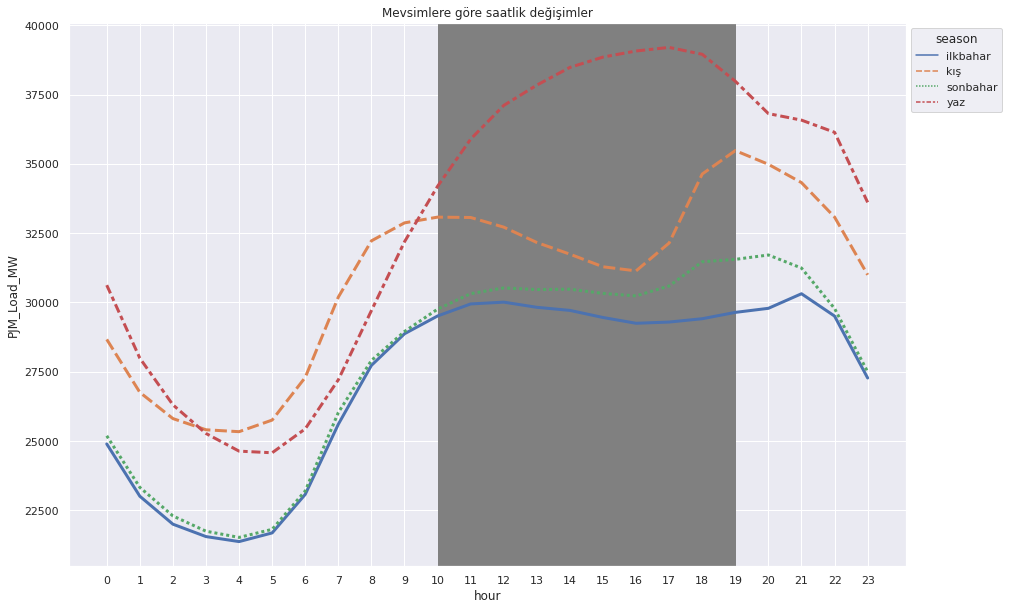

In [28]:
# Gri ile boyalı alan kışın  insanların işte olduğu vakitlerde elektrik tüketimi azalmakta fakat 
# Prime time(19.00 - 22.00)  zaman diliminde insalar işten dönüş evdeki elektrikli araçların çalışması(çamaşır mak.,bulaşık mak., gibi) elektrik tüketimi artıyor.
# Aynı şeyleri yaz ayları içinde söyleyebiliriz fakat burda şöyle bir durum var kışın ısınmak için illa elektriğe  ihtiyaç duyulmayabilir(hidrokarbon yakıtlar ile ısınma sağlanabilir)
# ama yaz aylarında soğutma için elektrik şart bu yüzden yaz döneminde gerek evlerde gerek iş yerlerinde soğutma için elektrik tüketilir buda yaz aylarında elektirk tüketim talebinin yüksek olmasını açıklar. 
# Gece saatlerinde elektrik tüketimi gün içine göre daha az gece activetenin azaldığını dünüşürsek bu mantıklı.

dum=data.groupby(['season','hour'])[['PJM_Load_MW']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.PJM_Load_MW,hue=dum.season,legend=all,linewidth=3,style=dum.season)
ax.set_title('Mevsimlere göre saatlik değişimler')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0,24));
plt.axvspan(10,19,color="gray") ;

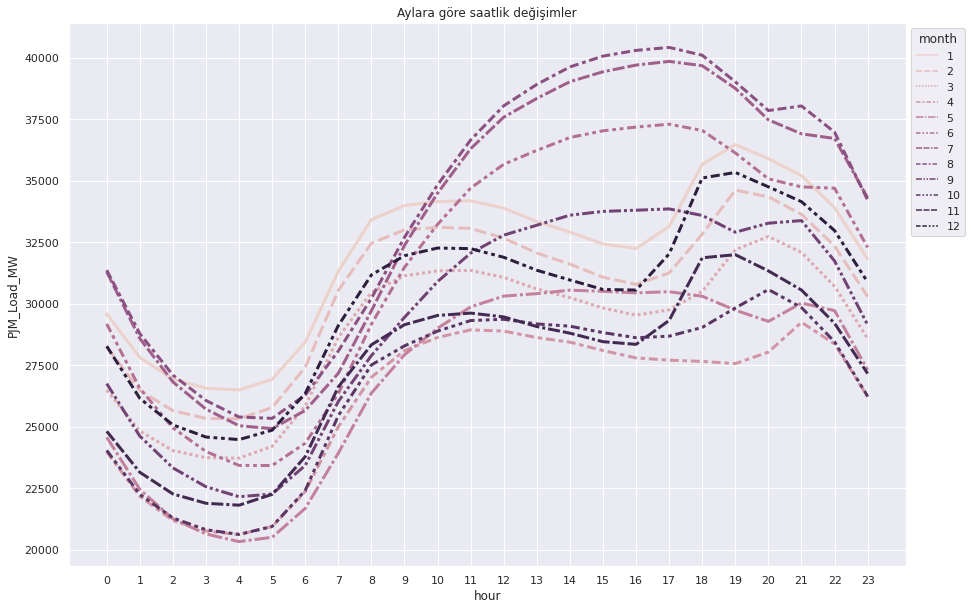

In [29]:
dum=data.groupby(['month','hour'])[['PJM_Load_MW']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.PJM_Load_MW,hue=dum.month,legend=all,linewidth=3,style=dum.month)
ax.set_title('Aylara göre saatlik değişimler')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0,24));

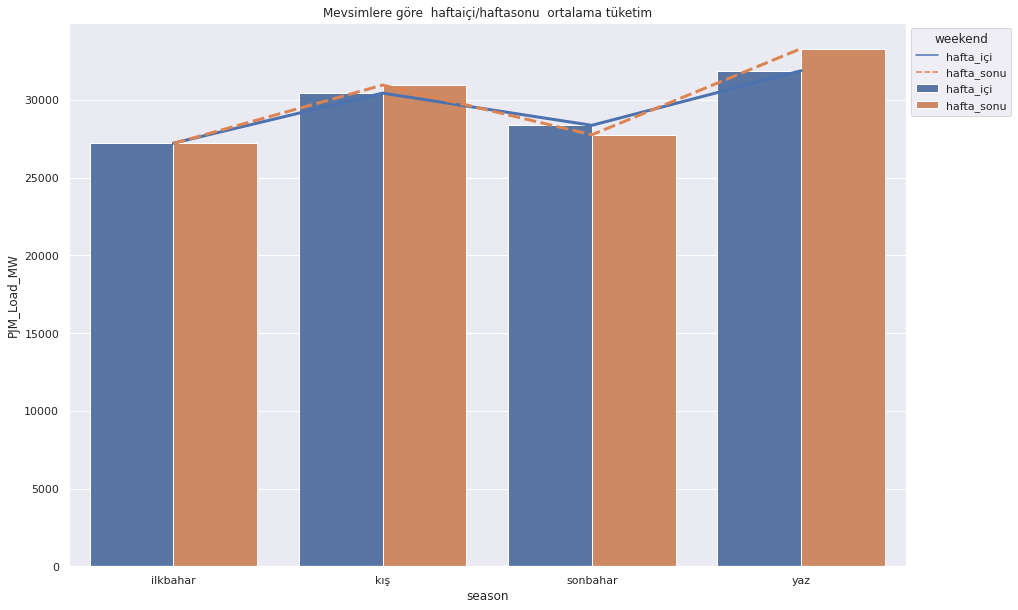

In [30]:
# Yaz ve Kış aylarında haftasonları elektrik tüketimi ortalaması daha yüksek.
# Yaz ayı için hafta içi insanların işte hafta sonları da evde olduğunu düşünürsek,iş te olmaları ev ısıtması için enerji tüketim talebini artırır hafta sonu evde soğutma için tüketim talebi daha fazla olabilir.
# Kış ayında ısınma talebi hafta sonu insanlar evde olduklarında daha fazla olabilri buda tüketimi artırabilir.
# Sonbahar ve İlkbahar ayları nispeten elektrik tüketimi daha az.
dum=data.groupby(['season','weekend'])[['PJM_Load_MW']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.season,y=dum.PJM_Load_MW,hue=dum.weekend,legend=all,linewidth=3,style=dum.weekend)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax=sns.barplot(x=dum.season,y=dum.PJM_Load_MW,hue=dum.weekend)
ax.set_title('Mevsimlere göre  haftaiçi/haftasonu  ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

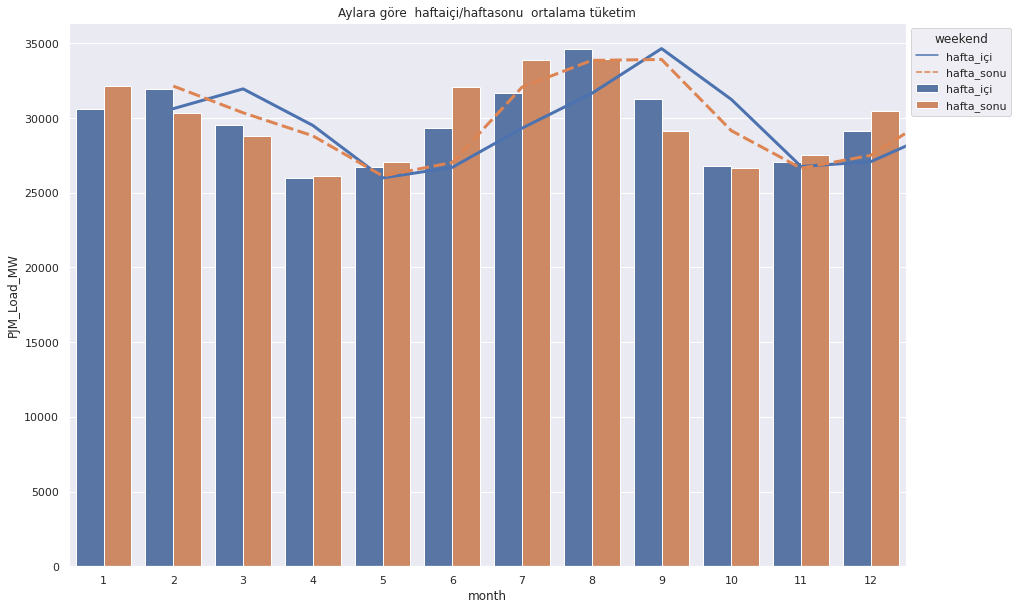

In [31]:
# İlkbahar ve sonbahar aylarına girerken hafta sonları enerji tüketimi hafta içine göre daha düşük
# İlkbahhar ve sonbahar aylarından cıkarken(yani yaz ve kış aylarına girmeye başladığımızda) bu durum tam tersine dönüyor.

dum=data.groupby(['month','weekend'])[['PJM_Load_MW']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.month,y=dum.PJM_Load_MW,hue=dum.weekend,legend=all,linewidth=3,style=dum.weekend)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax=sns.barplot(x=dum.month,y=dum.PJM_Load_MW,hue=dum.weekend)
ax.set_title('Aylara göre  haftaiçi/haftasonu  ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

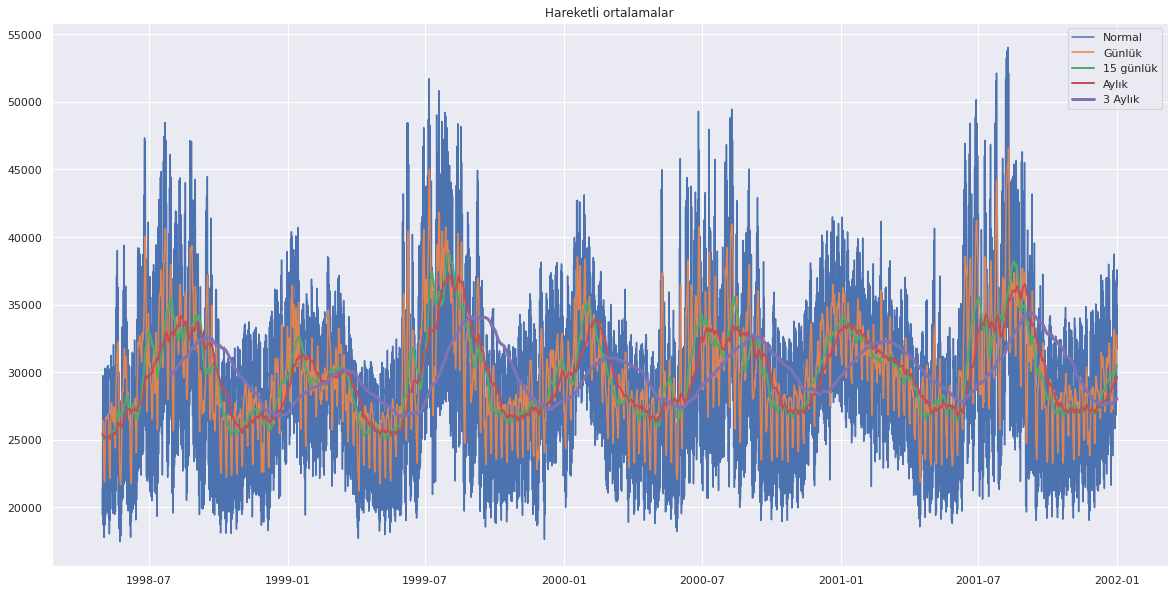

In [32]:
# Günlük,15 günlük ve Aylık hareketli ortalamalarını feature olarak ekledim.
data["PJM_Load_MW_roll"] = data["PJM_Load_MW"].rolling(24).mean()  # Günlük 
data["PJM_Load_MW_roll_2"] = data["PJM_Load_MW"].rolling(24*15).mean() # 15 günlük
data["PJM_Load_MW_roll_3"] = data["PJM_Load_MW"].rolling(24*30).mean() # Aylık
data=data.dropna()
plt.figure(figsize=(20,10))
plt.title('Hareketli ortalamalar')
plt.plot(data.PJM_Load_MW,label='Normal')
plt.plot(data.PJM_Load_MW_roll,label='Günlük')
plt.plot(data.PJM_Load_MW_roll_2,label='15 günlük',linewidth=2)
plt.plot(data.PJM_Load_MW_roll_3,label='Aylık',linewidth=2)
plt.plot(data["PJM_Load_MW"].rolling(24*30*3).mean(),label='3 Aylık',linewidth=3)
plt.legend();

* Forecasting modeli olarak XGBoost kullandım.
* Değerlendirme metriği olarak RMSE değerini göz önüne aldım( RMSE hata metriği tahmin edilen sonuçlarınızın gerçek değerlerde ne kadar farklı olduğunun ortalama değerini verir)

Dates train      : 1998-05-01 01:00:00 --- 2001-05-31 23:00:00  (n=27041)
Dates validation : 2001-05-31 23:00:00 --- 2001-12-31 20:00:00  (n=5133)
-------------------------------------------------------------------------------
data_train shape :(27041, 81), target_train shape :(27041,)
data_valid shape   :(5133, 81)  , target_valid shape   :(5133,)


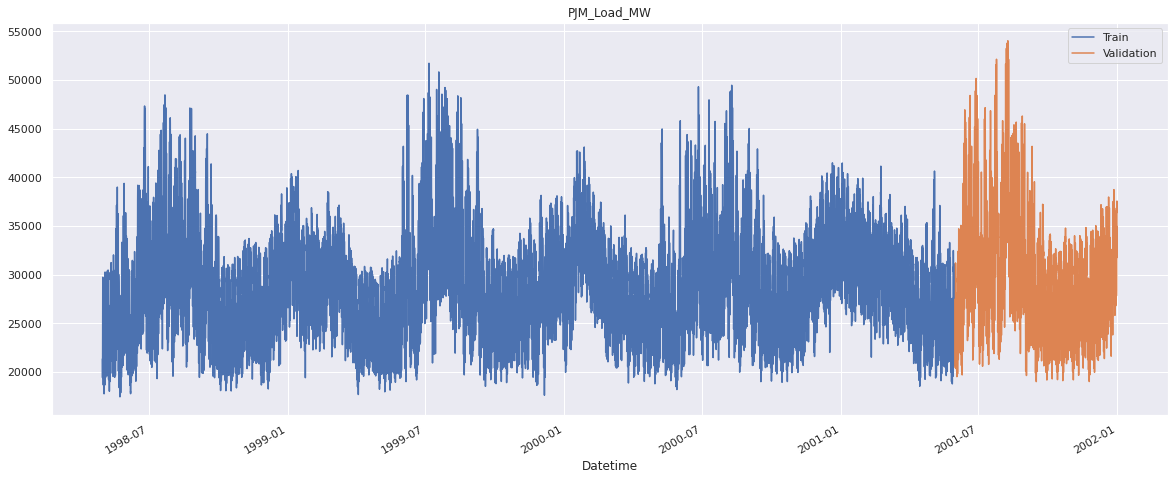

In [33]:
# Data daki döngüsel özellikler için modelin zamansal bir döngüde olduğunu anlamasına yardımcı olur.
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data
encode(data, 'dayofyear', 365)
encode(data, 'month', 12)


# **Train ve Validation split**
data2=data.drop(['date','dayofyear'],axis=1)
data_dum=pd.get_dummies(data2,prefix=None,prefix_sep='_',drop_first=True)
end_train = '2001-5-31 23:00:00'    #bu tarihe kadar olan kısım train sonrasını validation olarak alıyorum.
data_train = data_dum.loc[:end_train]
data_valid  = data_dum.loc[end_train:]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_valid.index.min()} --- {data_valid.index.max()}  (n={len(data_valid)})")
# # ==============================================================================
fig, ax = plt.subplots(figsize=(20, 8))
data_train['PJM_Load_MW'].plot(ax=ax, label='Train')
data_valid['PJM_Load_MW'].plot(ax=ax, label='Validation')
ax.set_title('PJM_Load_MW')
ax.legend();
# ==============================================================================
target_train=data_train.PJM_Load_MW.values
data_train=data_train.drop(['PJM_Load_MW'],axis=1)
target_valid=data_valid.PJM_Load_MW.values
data_valid=data_valid.drop(['PJM_Load_MW'],axis=1)

sc=StandardScaler()
data_train=sc.fit_transform(data_train)
data_valid=sc.transform(data_valid)
print('-------------------------------------------------------------------------------')
print(f'data_train shape :{data_train.shape}, target_train shape :{target_train.shape}')
print(f'data_valid shape   :{data_valid.shape}  , target_valid shape   :{target_valid.shape}')

#### Model de kullanılacak parametreler.

* 'lambda'   : Train aşamasında overfit olmasını engeller(artırdıkça model daha conservative olur).Bunu betaların sonuca olan hassasiyetini azaltarak yapar böylece bias'ı artırıp varyasımızı düşürür. 
* 'alpha'    : Train aşamasında overfit olmasını engeller(artırdıkça model daha conservative olur).Bunu betaların sonuca olan hassasiyetini azaltarak(nerdeyse 0 yapar) bias'ı artırıp varyasımızı düşürür.
* 'colsample_bytree': Her bir ağacı oluştururken değişknlerden alınan alt örnek oranıdır.
* 'subsample': XGBoost ağaç oluşturmadan önce verimizden alacağı örnek sayısını ayarlııyoruz mesala burda %80 nini kullan diyoruz.
* 'learning_rate':Modelin öğrenme hızı oranıdır.Eğer çok küçük olursa model  yavaş öğrenir eğer cok yüksek olursa model yerel minumuna ulaşamaz istenilen öğrenmeyi yakalayamaz.
* 'max_depth': Oluşturulan ağaçların max derinliği ne olmalı.Artırdıkça modelin overfit olma ihtimali artar.
* 'min_child_weight': Artırdıkça modelimiz  daha conservative olur.Agaç eğer Düğüm kısmında bölünmek istiyorsa min örnek ağırlı  'min_child_weight' değerinden büyük olması gerekir ki yaprak oluşabilsin.
* 'n_estimators': Tree sayısı
* 'tree_method':'gpu_hist'---> Modeli GPU üzerinde çalıştırmak için 

NOT: Model parametre değerlerine PARAMETRE TUNE aşamasında karar vereceğiz.

In [34]:
# ======================
# Parametre Tuning
# ======================

import optuna
def objective(trial,data=data_train,target=target_train):
    
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.08,0.009,0.01,0.012,0.014,0.016,0.018,0.001,0.1,0.5]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_method':'gpu_hist'
                }
    
    xgb_tuned=xgb.XGBRegressor(**param)
    xgb_tuned.fit(data,target)
    rmse =np.sqrt(mean_squared_error(target_valid,xgb_tuned.predict(data_valid)))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=80)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-15 11:13:43,701] A new study created in memory with name: no-name-4f817683-5a49-400c-968b-b41f0b4bec91
[I 2023-01-15 11:13:52,329] Trial 0 finished with value: 764.0015335381252 and parameters: {'lambda': 0.18824782020274952, 'alpha': 4.708507599965836, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 164}. Best is trial 0 with value: 764.0015335381252.
[I 2023-01-15 11:13:53,974] Trial 1 finished with value: 1022.7205605545004 and parameters: {'lambda': 0.05811862091520943, 'alpha': 0.4893449093573545, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 4, 'random_state': 48, 'min_child_weight': 267}. Best is trial 0 with value: 764.0015335381252.
[I 2023-01-15 11:14:09,315] Trial 2 finished with value: 639.803015624121 and parameters: {'lambda': 0.005399024798864817, 'alpha': 7.0764442849481775, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'max_dept

Number of finished trials: 80
Best trial: {'lambda': 0.00339325743964933, 'alpha': 0.7411089255253006, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'random_state': 24, 'min_child_weight': 47}


In [35]:
# En iyi sonucu veren parametre değerlerimiz.
study.best_trial.params

{'lambda': 0.00339325743964933,
 'alpha': 0.7411089255253006,
 'colsample_bytree': 0.9,
 'subsample': 0.8,
 'learning_rate': 0.08,
 'max_depth': 4,
 'random_state': 24,
 'min_child_weight': 47}

In [36]:
params= {
        'n_estimators': 1000, 
        'tree_method':'gpu_hist',
        }
params.update(study.best_trial.params) # En iyi sonuç veren paramtre değerleri params ile birleştirildi.

eval_set=[(data_train, target_train), (data_valid, target_valid)]
xgb_tuned=xgb.XGBRegressor( **params).fit(data_train,target_train,eval_metric=['rmse','mape'], eval_set=eval_set,verbose=False,early_stopping_rounds=100) 


print('Model train')
print('RMSE score: ',np.sqrt(mean_squared_error(target_train,xgb_tuned.predict(data_train))))
print('r2_score: ',r2_score(target_train,xgb_tuned.predict(data_train)))
print('MAPE score :',mean_absolute_percentage_error(target_train,xgb_tuned.predict(data_train)))
print('-----------------------------------------------------------------------')
print('Model valid')
print('RMSE score :',np.sqrt(mean_squared_error(target_valid,xgb_tuned.predict(data_valid))))
print('r2_score :',r2_score(target_valid,xgb_tuned.predict(data_valid)))
print('MAPE score :',mean_absolute_percentage_error(target_valid,xgb_tuned.predict(data_valid)))



Model train
RMSE score:  282.5712130793969
r2_score:  0.9975231259289613
MAPE score : 0.00690374036589477
-----------------------------------------------------------------------
Model valid
RMSE score : 453.18847517333717
r2_score : 0.9953173722913113
MAPE score : 0.008179448353220873


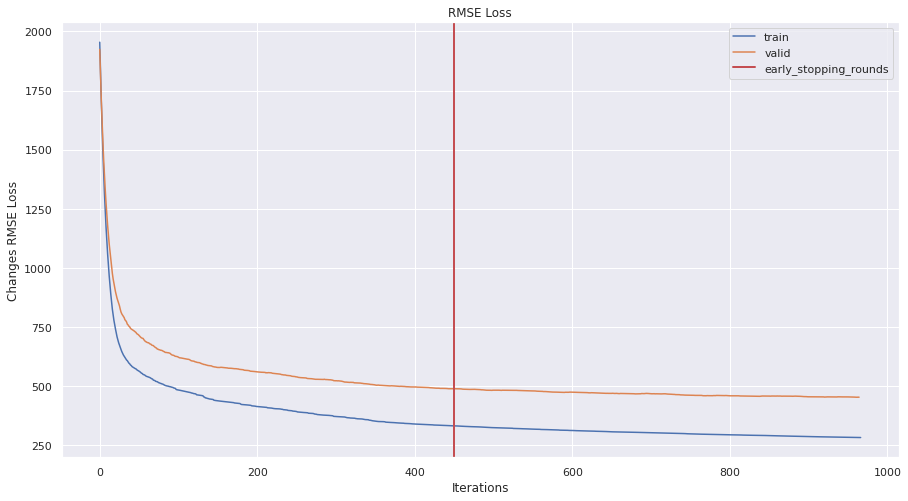

In [37]:
# Not: Daha net görülmesi için belli bir eşik değerin altındaki RMSE değerlerini  aldım.
# Modelin 450. iterasyondan sonra validation hatasını düüşlerin yavaşladığını gözlemliyoruz burda artık modelin overfit durumuna geçmeye başladığını söyleyebiliriz.
results=xgb_tuned.evals_result()
plt.figure(figsize=(15,8))
plt.title('RMSE Loss')
plt.plot(np.array(results['validation_0']['rmse'])[np.array(results['validation_0']['rmse'])<2000], label='train')
plt.plot(np.array(results['validation_1']['rmse'])[np.array(results['validation_1']['rmse'])<2000], label='valid')
plt.axvline(x=450, color='r', linestyle='-',label='early_stopping_rounds',linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Changes RMSE Loss')
plt.legend();

In [38]:
print(f'Verideki yüzdelik değişimlerin mutlak ortalamsı: {abs(data.PJM_Load_MW.pct_change()).mean()}')

Verideki yüzdelik değişimlerin mutlak ortalamsı: 0.03727872260107036


* MAPE : Tahminlerin oralamada gerçek değerden yüzde kaç saptığını gösterir.
* Model mape değeri olarak 0.008 veriyor.Gerçek değerden binde 8 lik bir sapma fena değil gibi tabi ama bunu neye dayanarak söyleyebiliriz.
* Şöyle düşündüm model kurmadan bir tahmin yapmak istersem muhtemelen bir önceki/sonraki saatin tüketim değerine bakar ve değişimlerin mutlak ortalaması kadar bir değişim aşağı veya yukarı yönlü olmuşur derim.Bu veride bu değer % 3.7.Buradan hareketle % 0.8 lik bir yakınlık ile tahmin bence fena sayılmaz.


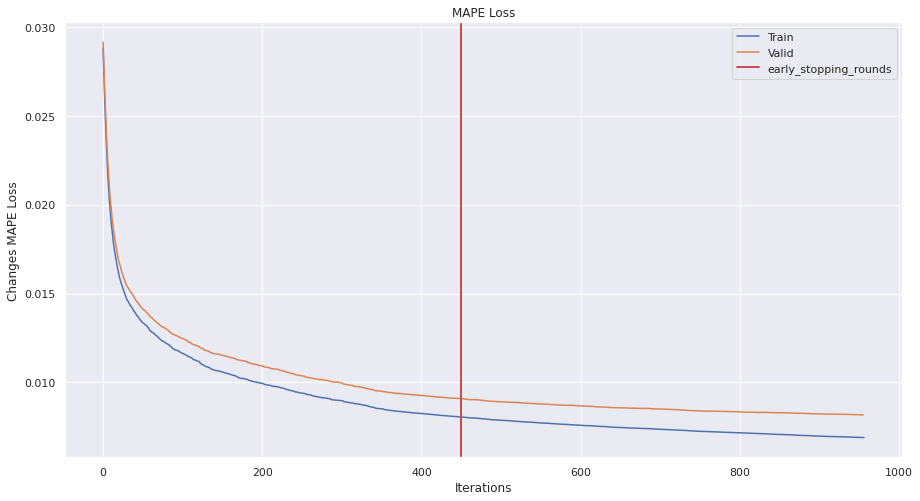

In [39]:
# Not: Daha net görebilmek için belirli bir değerin altındaki MAPE değerlerini çizdirdim.
# MAPE değeri  belirli bir iterasyondan sonra train setinde düşüş devam ederken validation setimizde değişimler çok küçük oluyor 
# Bu noktadan sonra modelin artık overfit olmaya başladığını,genelleme yapmakta zorlandığını söyleyebiliriz.
# Grafikte Validation MAPE değeri 450. iterasyondan sonra artık yavaş yavaş train MAPE değerininden ayrılmanın başladığını görüyoruz.
plt.figure(figsize=(15,8))
plt.title('MAPE Loss')
plt.plot(np.array(results['validation_0']['mape'])[np.array(results['validation_0']['mape'])<0.03], label='Train')
plt.plot(np.array(results['validation_1']['mape'])[np.array(results['validation_1']['mape'])<0.03], label='Valid')
plt.axvline(x=450, color='r', linestyle='-',label='early_stopping_rounds',linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Changes MAPE Loss')
plt.legend();

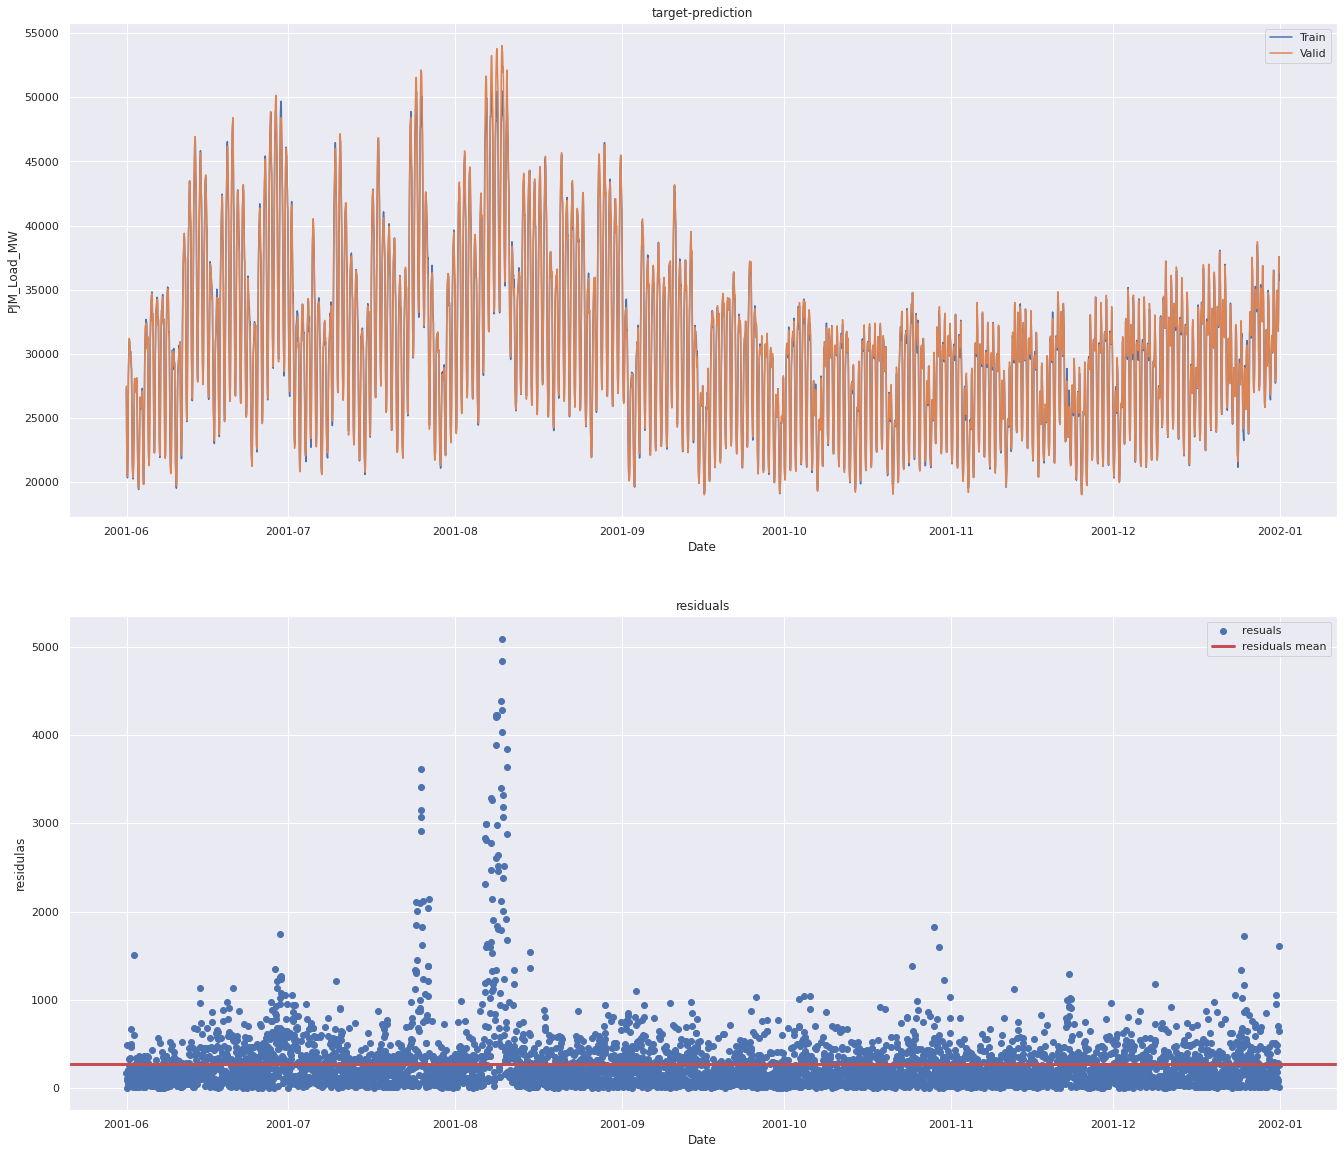

In [40]:
# Genel olarak model yaz aylarında daha büyük hatalar vermiş bunu normal karşılanabilir.
# Outlier diyebileceğimiz aşırı prime time zamanlar genelde yaz aylarında gözlemlendi.Buralarda model hatası yüksek ki bu normal bunları yakalayabilmek için dış kaynak verilerine ihtiyacımız olabilir hava sıcaklığı gibi.


pred_valid=xgb_tuned.predict(data_valid)
df_val=pd.DataFrame(data={'pred_valid':pred_valid,
                          'target_valid':target_valid,
                           'residuals_valid':abs(pred_valid-target_valid)},index=data[-len(data_valid):].index)
plt.figure(figsize=(50,20))
plt.subplot(2,2,1)
plt.title('target-prediction')
plt.plot(df_val.pred_valid, label='Train')
plt.plot(df_val.target_valid, label='Valid')
plt.xlabel('Date')
plt.ylabel('PJM_Load_MW')
plt.legend();
plt.subplot(2,2,3)
plt.title('residuals')
plt.scatter(x=df_val.index,y=df_val.residuals_valid, label='resuals')
plt.axhline(y=df_val.residuals_valid.mean(), color='r', linestyle='-',label='residuals mean',linewidth=3)
plt.xlabel('Date')
plt.ylabel('residulas')
plt.legend();